# Imports and functions

In [1]:
%matplotlib inline
import pickle
import numpy as np
import matplotlib.pyplot as plt
from open_walk_analysis import *

# Load data

In [2]:
folder = "full-state-predictions"
dataset = 0

with open(folder+"/results/walks-actual"+str(dataset)+".pickle", "rb") as f:
    edges0 = pickle.load(f)
with open(folder+"/results/walks-predicted2-"+str(dataset)+".pickle", "rb") as f:
    edges2 = pickle.load(f)

seq = edges0[0][0][0]

In [3]:
def top_path(G): 
    # Find center of G
    source = get_source_node(G)
    # Find moves away from center
    rings = ring_levels(G, source)
    # Get further derived sequences
    try:
        ends = rings[6] # only 6 moves away

        # Build a dictionary of node flux to 
        options = dict([(end, G.node[end]['flux']) for end in ends])

        sequences = np.array(list(options.keys()))
        fluxes = np.array(list(options.values()))

        # Find the highest flux sequence
        most_probable_node = np.argmax(fluxes)
        max_seq = sequences[most_probable_node]

        # Return that sequence
        return (source, max_seq)
    except: 
        return None

In [4]:
dfluxes = dict([(i, []) for i in range(7)])
gpms = {}

# Iterate through many datasets
for d in range(0, 5):
    
    # Load dataset
    with open(folder+"/results/walks-actual"+str(d)+".pickle", "rb") as f:
        edges0 = pickle.load(f)
    
    with open(folder+"/results/walks-predicted2-"+str(d)+".pickle", "rb") as f:
        edges2 = pickle.load(f)    
    
    # Formulate as networks
    G0, G2, Gdiff = build_graphs(edges0, edges2)
    rings = ring_levels(Gdiff, get_source_node(Gdiff))

    # Add to summary statistic
    for ring, sequences in rings.items():

        if  ring < 7:

            diff, denom1, denom2 = 0, 0, 0
            for i in sequences:

                # Add up total flux exchange, and the difference between two networks
                for j in Gdiff.neighbors(i):

                    diff += Gdiff.edge[i][j]["weight"]
                    try: denom1 += G0.edge[i][j]["delta_flux"]
                    except: pass

                    try: denom2 += G2.edge[i][j]["delta_flux"]
                    except: pass

            denom = denom1 + denom2

            # Normalize the flux exchange at this hamming distance
            if denom != 0:
                dfluxes[ring].append(diff/denom)
            elif diff == 0: pass
            else:
                dfluxes[ring].append(0)

    gpms[d] = top_path(G0)

/Users/Zsailer/.virtualenvs/py3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/Zsailer/.virtualenvs/py3/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


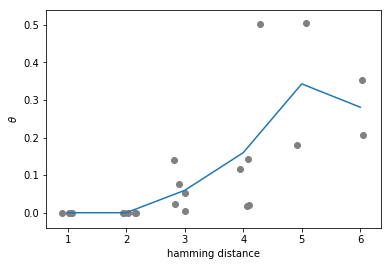

In [5]:
fig, ax = plt.subplots()
means = []
for key, val in dfluxes.items(): 
    #if key > 0:
    y = np.array(val)
    ymean = np.mean(y)
    x = np.ones(len(y)) * (key+1)
    xjitter = x + np.random.randn(len(x))* .1
    ax.scatter(xjitter,y, marker="o", color="gray", alpha=1)
    means.append(ymean)

x = range(1, 8)
y = means
ax.plot(x,y)
ax.set_xlabel("hamming distance")
ax.set_ylabel("$\\theta$")

In [6]:
from gpmap.utils import binary_mutations_map
from latticegpm import LatticeGenotypePhenotypeMap
from latticeproteins.conformations import Conformations
from epistasis.models import EpistasisLinearRegression

In [49]:
def epistasis_between_pair(pair, target):
    """Calculate the epistasis between two sequences"""
    # Prepare for GenotypePhenotypeMap
    wildtype = pair[0]
    length = len(wildtype)
    mutations = binary_mutations_map(*pair)
    c = Conformations(length)

    # Construct a genotype-phenotype map
    gpm = LatticeGenotypePhenotypeMap(wildtype, mutations=mutations, target_conf=target)
    gpm.fold(Conformations=Conformations(12))

    # Fit a high-order epistasis model
    model = EpistasisLinearRegression.from_gpm(gpm, order=7, model_type="local")
    model.fit()

    epistasis = []
    for i in range(1,8):
        z = model.epistasis.get_orders(i)
        epistasis.append(np.mean(z.values))

    return epistasis